<a href="https://colab.research.google.com/github/1V1a1l8/1V1a1l8/blob/main/VC/3_sobel_canny_edge_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Visión computacional para imágenes y video (Gpo 10) - TC4033.10

### Actividad: 3.2 Google Colab - Algoritmos de mejoramiento de imágenes en el dominio espacial

#### Miembros del equipo:

##### Diana Valeria García Briones - A01793006
##### Herbert Joadan Romero Villarreal - A01794199
##### Julián Valera Juárez - A01793875
##### Ivan Lee Cancino - A01793491
##### Karina Zafra Vallejo - A01793979


#### Docentes:
##### Dr. Gilberto Ochoa Ruiz - Profesor Titular
##### María Guadalupe Marcos Abularach - Profesor Asistente

<br>

# 3. Sobel and Canny Edge Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Sobel Edge Detection](#sobel)
3. [Canny Edge Detection](#canny)

## Actividad en Equipo
4. [Ejercicio 1](#ej1)
5. [Ejercicio 2](#ej2)
6. [Ejercicio 3](#ej3)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
import skimage.color as sc
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import median_filter as med

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Sobel Edge Detection <a class="anchor" id="sobel" ></a>

As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values.

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions.
3. Compute the magnitude of the gradient.
4. Normalize the gradient values.

In [ ]:
def edge_sobel(image):
    #from scipy import ndimage
    #import skimage.color as sc
    #import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

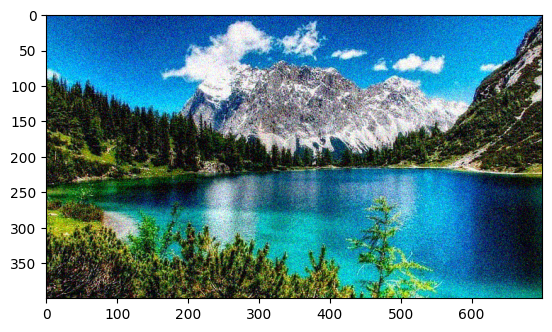

In [ ]:
original_image = np.load('/content/drive/Shareddrives/Equipo 12 - Vision/RepoGithub/data/img.npy')

img = skimage.util.random_noise(original_image)
plt.imshow(img)

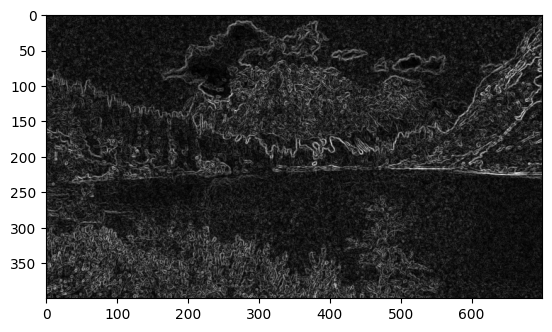

In [ ]:
img_med = med(img, size=2)
img_edge = edge_sobel(img_med)
plt.imshow(img_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

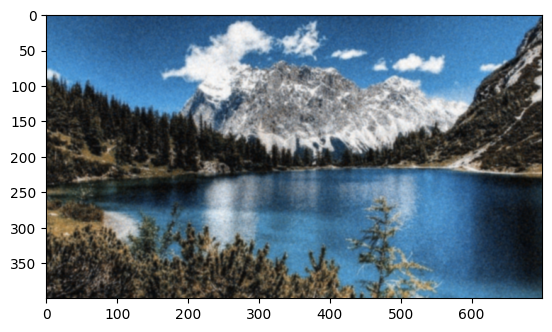

In [ ]:
img_gauss = gauss(img, sigma=1)
plt.imshow(img_gauss)

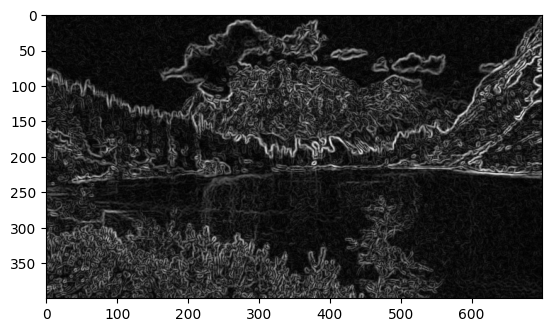

In [ ]:
img_edge = edge_sobel(img_gauss)
plt.imshow(img_edge, cmap="gray")

## Canny Edge Detection <a class="anchor" id="canny" ></a>

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

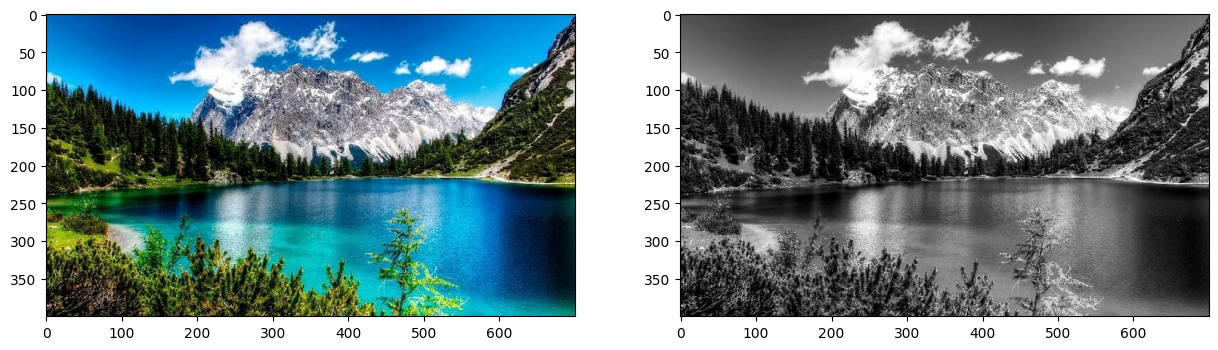

In [ ]:
img = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/RepoGithub/data/image.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [ ]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [ ]:
kernel_size = 3

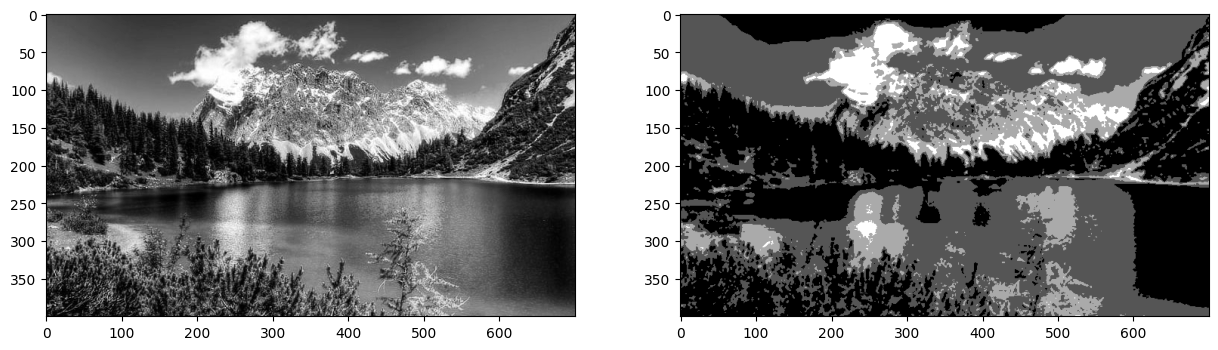

In [ ]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity.

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions:
- horizontal $(x)$
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [ ]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

<ipython-input-13-dddc2aedcd55>:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-13-dddc2aedcd55>:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


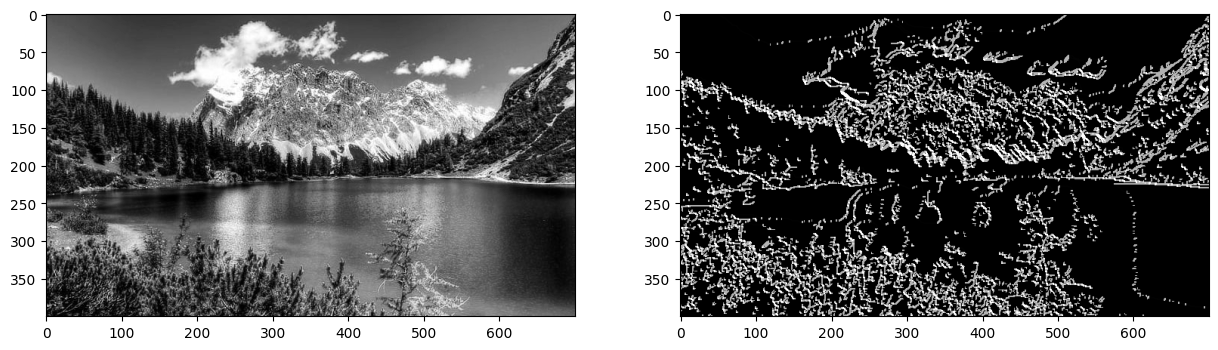

In [ ]:
G, theta = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

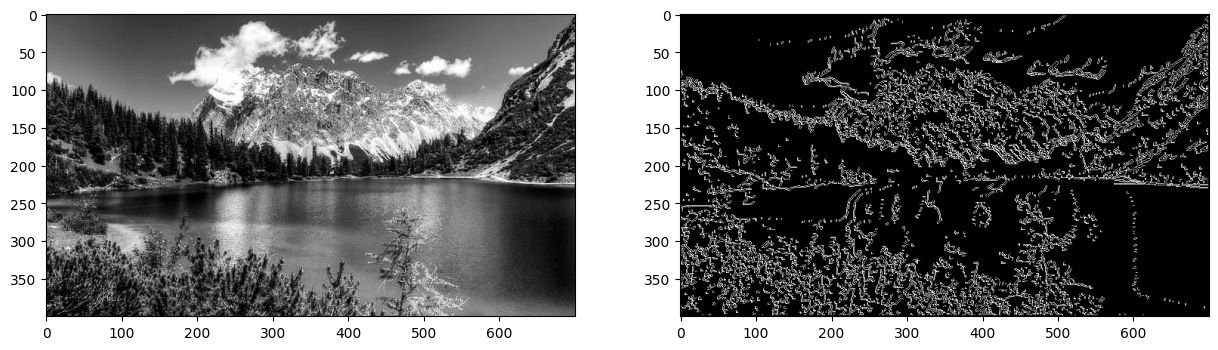

In [ ]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

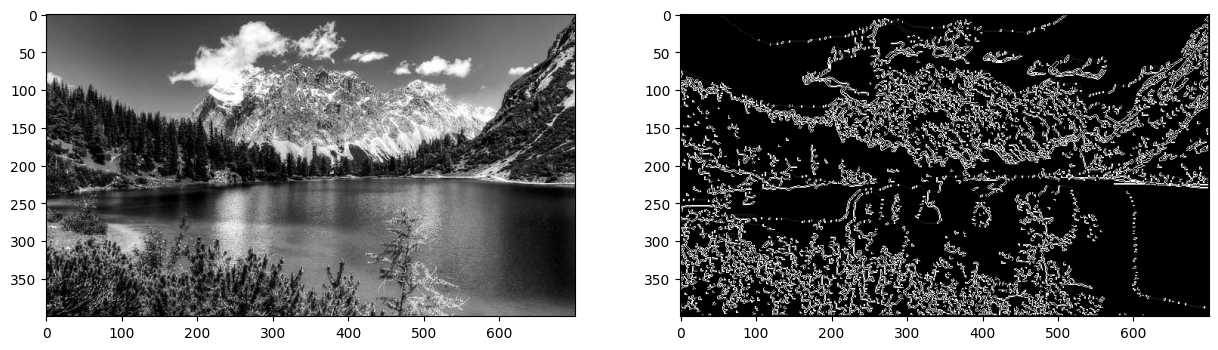

In [ ]:
img_threshold = threshold(img_nonmax)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [ ]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

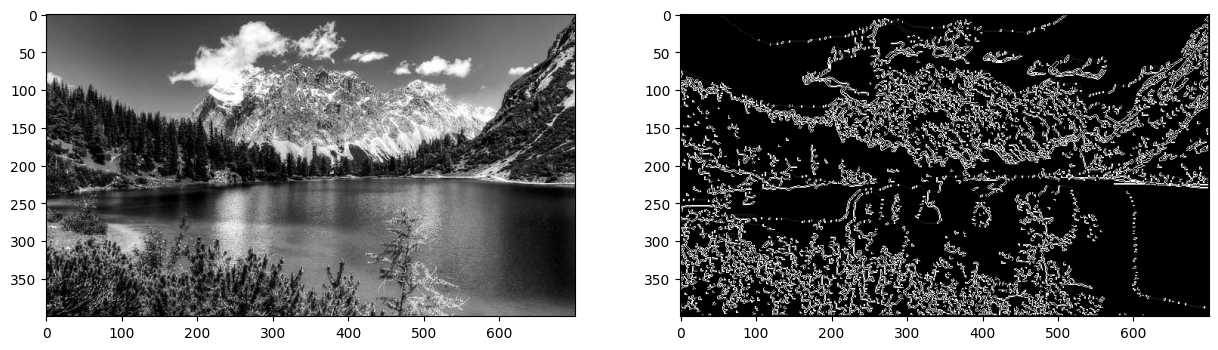

In [ ]:
img_final = hysteresis(img_threshold)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

## Ejercicio 1 <a class="anchor" id="ej1" ></a>

Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

### 1a. Prewitt

In [ ]:
# Kernel convolution function
def convol(img, kernel):
    # image height and width
    img_height = img.shape[0]
    img_width = img.shape[1]

    # kernel height and width
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]

    h = (kernel_height - 1) // 2
    w = (kernel_width - 1) // 2

    # output image matrix
    out = np.zeros((img_height, img_width))

    # iterate over every pixel of the image
    for i in np.arange(h, img_height-h):
        for j in np.arange(w, img_width-w):
            sum = 0
            # iterate over the kernel
            for k in np.arange(-h, h+1):
                for l in np.arange(-w, w+1):
                    # get the corresponding image pixel value
                    a = img[i+k, j+l]
                    z = kernel[h+k, w+l]
                    sum += (z * a)
            out[i, j] = sum

    return out

In [ ]:
# Define Prewitt kernels
Px = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], np.float32)  # Horizontal kernel
Py = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], np.float32)  # Vertical kernel

print('Kernel Prewitt horizontal:\n')
print(Px,'\n')
print('Kernel Prewitt vertical:\n')
print(Py)

Kernel Prewitt horizontal:

[[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]] 

Kernel Prewitt vertical:

[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


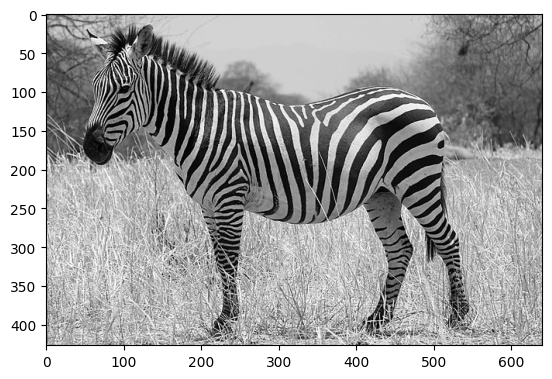

In [ ]:
image1 = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/Actividad3/zebra.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image1, cmap='gray')

In [ ]:
# Calculate the x and y gradients using the Prewitt kernels
prew_x = convol(image1, Px)
prew_y = convol(image1, Py)

In [ ]:
# Calculate the magnitude of the gradient
prew_out = np.sqrt(np.power(prew_x, 2) + np.power(prew_y, 2))
# Map the values to range 0-255
prew_out = (prew_out / np.max(prew_out)) * 255

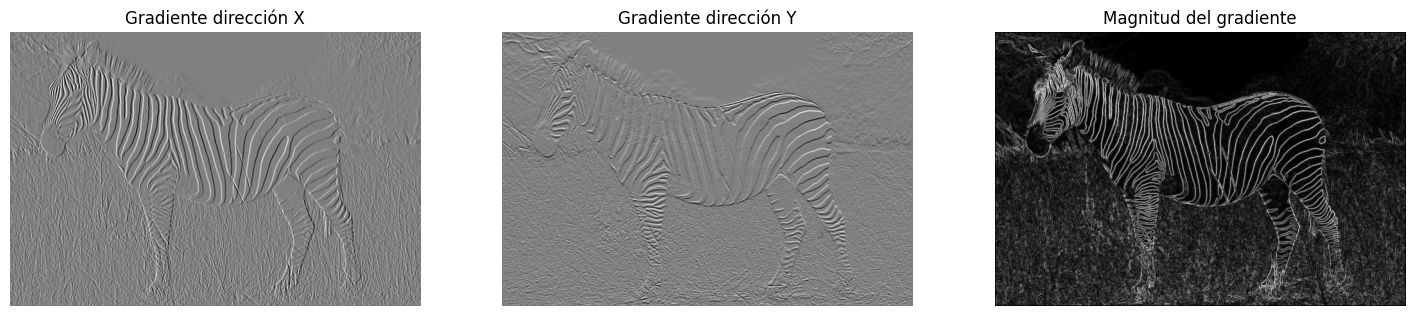

In [ ]:
fig = plt.figure(figsize=(18, 16))

a = fig.add_subplot(1,3,1)
imgplot = plt.imshow(prew_x, cmap='gray')
a.set_title('Gradiente dirección X')
a.axis('off')

a = fig.add_subplot(1,3,2)
imgplot = plt.imshow(prew_y, cmap='gray')
a.set_title('Gradiente dirección Y')
a.axis('off')

a = fig.add_subplot(1,3,3)
imgplot = plt.imshow(prew_out, cmap='gray')
a.set_title('Magnitud del gradiente')
a.axis('off')

plt.show()

### 1b. Sobel

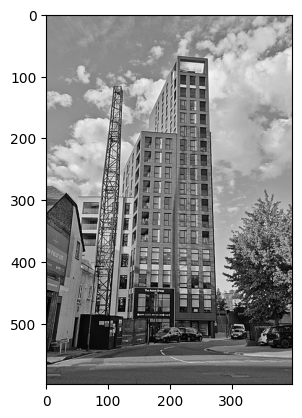

In [ ]:
image2 = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/Actividad3/london.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image2, cmap='gray')

In [ ]:
# Define Sobel kernels
Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)  # Horizontal kernel
Sy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)  # Vertical kernel

print('Kernel Sobel horizontal:\n')
print(Sx,'\n')
print('Kernel Sobel vertical:\n')
print(Sy)

Kernel Sobel horizontal:

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]] 

Kernel Sobel vertical:

[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]


In [ ]:
# Calculate the x and y gradients using the Sobel kernels
sob_x = convol(image2, Sx)
sob_y = convol(image2, Sy)

In [ ]:
# Calculate the magnitude of the gradient
sob_out = np.sqrt(np.power(sob_x, 2) + np.power(sob_y, 2))
# Map the values to range 0-255
sob_out = (sob_out / np.max(sob_out)) * 255

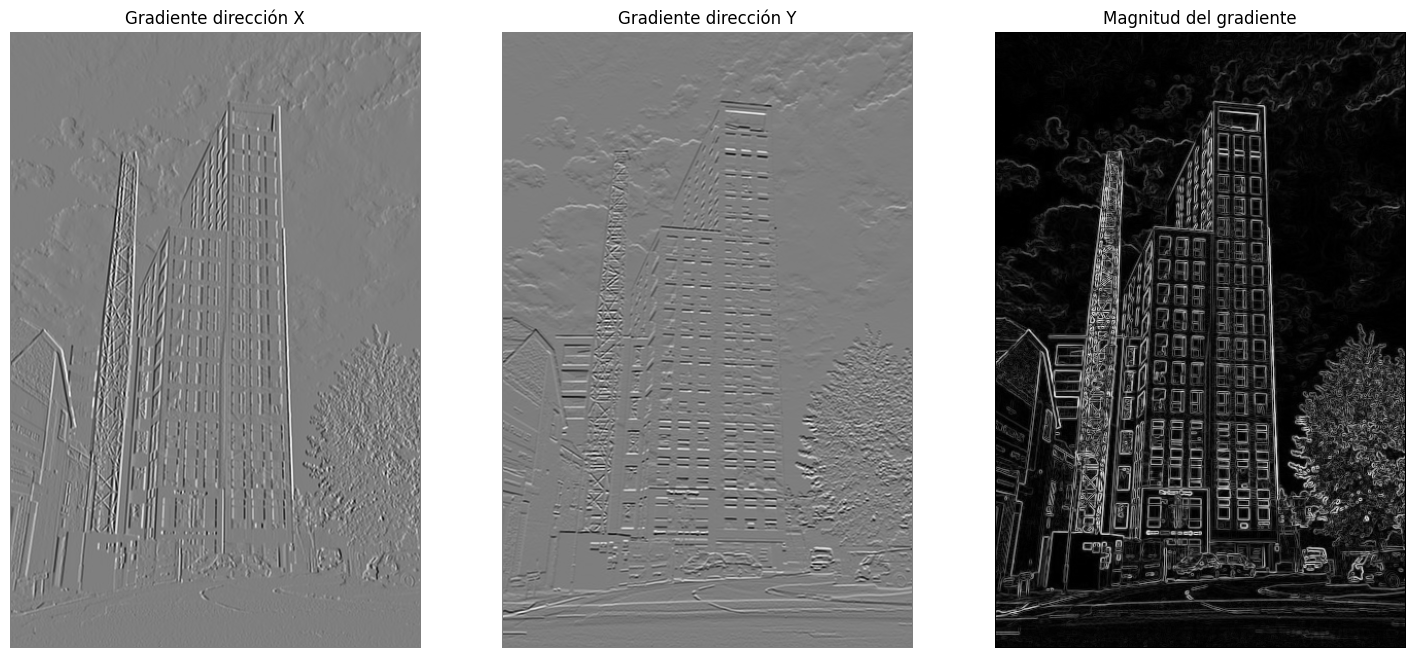

In [ ]:
fig = plt.figure(figsize=(18, 16))

a = fig.add_subplot(1,3,1)
imgplot = plt.imshow(sob_x, cmap='gray')
a.set_title('Gradiente dirección X')
a.axis('off')

a = fig.add_subplot(1,3,2)
imgplot = plt.imshow(sob_y, cmap='gray')
a.set_title('Gradiente dirección Y')
a.axis('off')

a = fig.add_subplot(1,3,3)
imgplot = plt.imshow(sob_out, cmap='gray')
a.set_title('Magnitud del gradiente')
a.axis('off')

plt.show()

###1c. Laplaciano

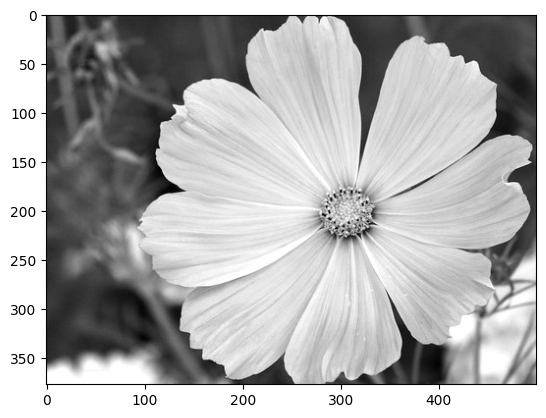

In [ ]:
image3 = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/Actividad3/flor.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image3, cmap='gray')

In [ ]:
def Laplacian(imagen3):
  laplacianX = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

  laplacianY = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

  #normalizing the vectors
  Lap_x = convolve(imagen3, laplacianX) / 28.0
  Lap_y = convolve(imagen3, laplacianY)  / 28.0

  #calculate the gradient magnitude of vectors
  lap = np.sqrt(np.power(Lap_x, 28) + np.power(Lap_y, 28))
  # mapping values from 0 to 255
  lap = (lap / np.max(lap)) * 255


  return lap

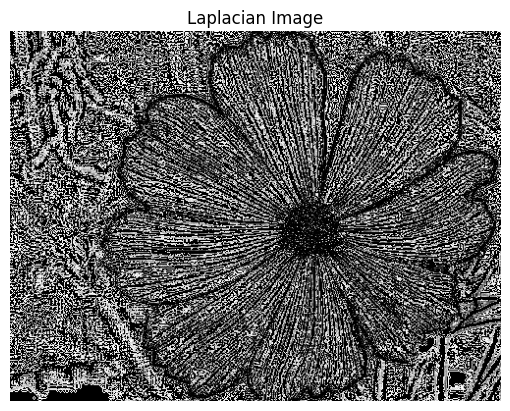

In [ ]:
import matplotlib.pyplot as plt

# Aplicar el filtro Laplaciano
lap = Laplacian(image3)

# Mostrar la imagen resultante
plt.imshow(lap, cmap='gray')
plt.title('Laplacian Image')
plt.axis('off')  # Desactivar ejes para mejor visualización
plt.show()

### Conclusiones

Prewitt y Sobel son métodos de gradiente  basados en la derivada de primer orden, ambas usan convolución de 3x3 por lo tanto el costo computacional es el mismo. Prewitt proporciona mayor inmunidad al ruido, le da la misma relevancia a la vecindad horizontal y vertical de un pixel cuando combina sus dos componentes de gradiente. En cambio, Sobel es más sensible a los bordes diagonales.
Por otra parte, el Laplaciano es una medida bidimensional isotrópica basado en la derivada de segundo orden de una imagen, es mucho más sensible al ruido, esta se suele utilizar en detección de puntos aislados.

En los tres casos la complejidad computacional es: **O(mn)** donde **m** y **n** son las dimensiones de la imagen. Por lo tanto, la complejidad en tiempo es lineal con respecto al número de pixeles de la imágen. La operación de convolucion es el principal factor que contribuye en la complejidad computacional de los tres algorítmos.

Prewitt y Sobel tienen fórmulas separadas para calcular el gradiente en X-Y, la magnitud y la dirección, en cambio el Laplaciano solo hace un solo cálculo. Sin embargo, es más efectivo usar el gradiente (al menos en las imagenes que se estudiaron en este ejercicio)

Al final, cada uno tiene sus ventajas y desventajas, en algunas aplicaciones se deberán combinar los gradientes y el laplaciano para detectar lo que realmente se está buscando. Tambien es importante mencionar que el tiempo de ejecución de cada algoritmo puede variar dependiendo de la implementación y técnicas de optimización utilizadas.

## Ejercicio 2 <a class="anchor" id="ej2" ></a>

Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

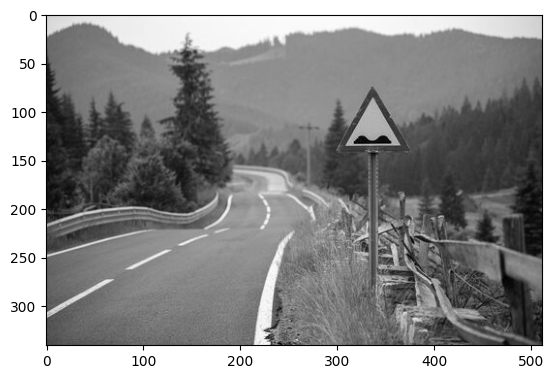

In [ ]:
# Primero cargamos la imagen en escala de grises
image4 = cv2.imread('/content/drive/Shareddrives/Equipo 12 - Vision/Actividad3/senal.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image4, cmap='gray')

Vamos a definir una funcion en donde usemos el filtro Sobel previamente inicializado sobre nuestra imagen original para obtener los gradientes en X, Y.

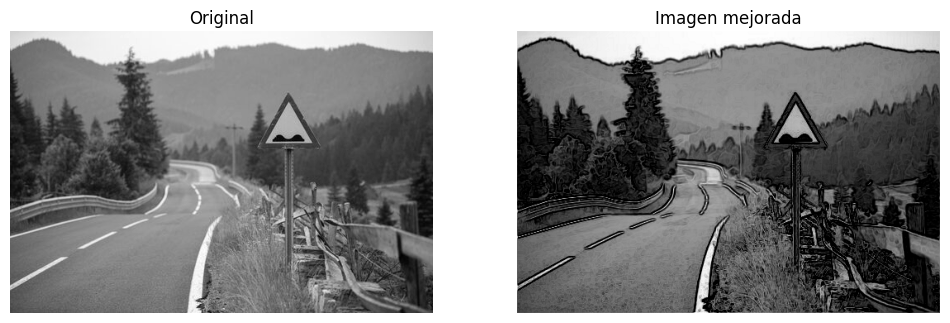

In [ ]:
# Funcion que recibe una imagen en escala de grises
# Y un factor alpha

def realce_lineas(imagen, factor_alpha):
  # Calcular los valores de x y y utilizando el grafiente
  sobel_x = convol(imagen, Sx)
  sobel_y = convol(imagen, Sy)

  # Calcular la magnitud del gradiente
  sob_out = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))

  # Mapeo de los valores en el rango 0-255
  sob_out = (sob_out / np.max(sob_out)) * 255

  # Multiplicar la magnitud del gradiente por el factor_alpha
  imagen_realzada = np.clip(sob_out * factor_alpha, 0, 255).astype(np.uint8)

  # Aplicar la diferencia entre la imagen original y la imagen realzada
  imagen_final = cv2.subtract(imagen, imagen_realzada)

  return imagen_final

# Factor de realce (Mayor a 1 como se requiere en el ejercicio)
factor_alpha = 2.0

# Aplicar el algoritmo de realce de líneas
imagen_realzada = realce_lineas(image4, factor_alpha)

# Ahora solamente mostramos las figuras original vs mejorada
fig = plt.figure(figsize=(12, 8))

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(image4, cmap='gray')
a.set_title('Original')
a.axis('off')

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(imagen_realzada, cmap='gray')
a.set_title('Imagen mejorada')
a.axis('off')

plt.show()

El filtro de sobel crea una imagen resultante que resalta los bordes, logrando un efecto de realce que resulta especialmente util en aplicaciones donde la deteccion de bordes es fundamental, como en la segmentación de objetos en una imagen.

## Ejercicio 3 <a class="anchor" id="ej3" ></a>

Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes.

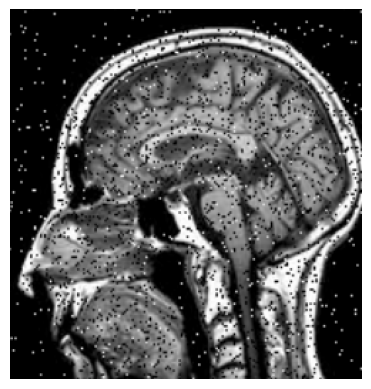

In [ ]:
import matplotlib.pyplot as plt

#Leer la imagen
image5 = plt.imread('/content/drive/Shareddrives/Equipo 12 - Vision/Actividad3/head.png')
plt.axis('off')
plt.imshow(image5, cmap='gray')

Inicialmente leemos la imagen de rayos X de un PET, corrompida por ruido de sal y pimienta posteriormente utilizaremos las técnicas Filtro de Mediana (Median Filter) y Filtro Gaussiano (Gaussian Filter) comunes de procesamiento de imágenes para mejorar la calidad al reducir el ruido y mejorar la apariencia visual

### Reduccion de ruido utilizando un kernel de filtro de paso bajo gaussiano de 19 × 19 con sigma (s) igual a 3.

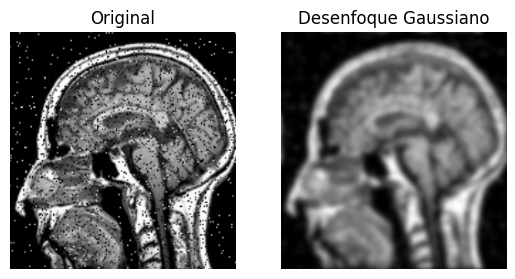

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Función para convertir una imagen a escala de grises
def read_image(image):
    # Si la imagen es a color (3 canales), se toma el promedio de los canales para convertirla a escala de grises
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    return image

# Función para generar un kernel gaussiano dado su tamaño y sigma
def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

# Función que aplica un desenfoque gaussiano a una imagen dada
def gaussian_blur(image, kernel):
    return convolve2d(image, kernel, mode='same', boundary='wrap')

# Se convierte la imagen a escala de grises
image6 = read_image(image5)

# Se define el tamaño y sigma del kernel gaussiano
kernel_size = 19
sigma_value = 3
gaussian_kernel = gaussian_kernel(kernel_size, sigma_value)

# Se aplica un desenfoque gaussiano a la imagen
gaussian_img = gaussian_blur(image6, gaussian_kernel)

# Se muestra la imagen original y la imagen después de aplicar el desenfoque gaussiano
plt.subplot(1, 2, 1), plt.imshow(image6, cmap='gray'), plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(gaussian_img, cmap='gray'), plt.title('Desenfoque Gaussiano')
plt.axis('off')
plt.show()

### Reduccion de ruido utilizando un filtro de mediana de 7 × 7.

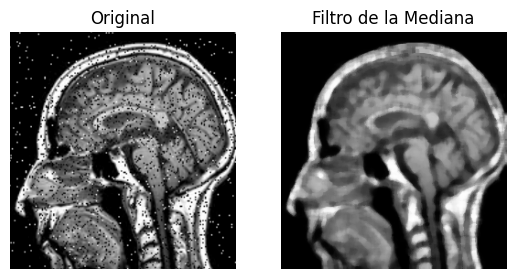

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función para convertir una imagen a escala de grises
def read_image(image):
    # Si la imagen es a color (3 canales), se toma el promedio de los canales para convertirla a escala de grises
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)
    return image

# Función que aplica un filtro de la mediana a una imagen
def median_filter(image, filter_size):
    # Se agrega un borde reflejado a la imagen para manejar los píxeles en el borde
    padded_image = np.pad(image, filter_size // 2, mode='reflect')
    result_image = np.zeros_like(image)

    # Iteración sobre cada píxel de la imagen original
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Se aplica la operación de mediana a la vecindad del píxel actual
            result_image[i, j] = np.median(padded_image[i:i+filter_size, j:j+filter_size])

    return result_image

# Se convierte la imagen a escala de grises
image7 = read_image(image5)

# Se define el tamaño del filtro de la mediana
med = 7

# Se aplica un filtro de la mediana de tamaño 7x7
median = median_filter(image7, med)

# Se muestra la imagen original y la imagen después de aplicar el filtro de la mediana
plt.subplot(1, 2, 1), plt.imshow(image7, cmap='gray'), plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2), plt.imshow(median, cmap='gray'), plt.title('Filtro de la Mediana')
plt.axis('off')
plt.show()

Para esta actividad el filtro con mejores resultados es el de la mediana dandonos una imagen un poco mas nitida puede estar relacionado debido a que es robusto ante valores atípicos (outliers) en los datos contrario al filtro Gaussiano.



---



Bibliografía
* Tsankashvili, N. (2018, January 20). Comparing edge detection methods. Medium. https://medium.com/@nikatsanka/comparing-edge-detection-methods-638a2919476e
* Gonzalez, R. & Woods, R. (2018). Digital Image Processing.  4° Edition. Pearson.
* Parik, D. (s.f.). *Edge Detection using Laplacian Filter*. OpenGenus. https://iq.opengenus.org/laplacian-filter/
* Olawanle, J. (2022, 5 de octubre). *Big O Cheat Sheet – Time Complexity Chart*. FreeCodeCamp. https://www.freecodecamp.org/news/big-o-cheat-sheet-time-complexity-chart/